# IBX Land Value Uplift and Value Capture Pipeline (MapPLUTO + DOF Market Land Values)

This notebook implements a modular geospatial and fiscal analysis pipeline to estimate how the proposed **Interborough Express (IBX)** could increase **land values** and **property tax revenue** in New York City, using:

- **Parcel geometries and assessed land/total values** from NYC Department of City Planning’s **MapPLUTO** feature layer.
- **Current market land/total values** from NYC Department of Finance’s parcel-level **assessment CSV**.
- **Proposed expansion (i.e. IBX) station locations** from `data/proposed_lines/stations_[xxx].geojson`, which provides the coordinates of each proposed station along the alignment - entered manually.

The pipeline is loosely modeled on the value-capture framework used by Gupta, Van Nieuwerburgh, and Kontokosta in *“Take the Q Train: Value Capture of Public Infrastructure Projects”* (NBER Working Paper 26789), adapted to a simpler, parcel-based implementation.

**Key data linkages and fields:**

- **Geometry & parcel IDs:** MapPLUTO 25v3  
  - CRS: `EPSG:2263` (NAD83 / New York Long Island, US feet).  
  - IDs: `BoroCode`, `Block`, `Lot`, `BBL`.  
  - Assessed land: `AssessLand`.  
  - Ownership & use: `OwnerType` (type of ownership) and `LandUse` (01–11 land-use categories).

- **Valuations:** DOF assessment CSV  
  - IDs: `BORO`, `BLOCK`, `LOT` → constructed **BBL**.  
  - DoF's `CURMKTLAND` and `CURMKTTOT`.
  - MapPLUTO’s `AssessLand` and `AssessTot`.

- **IBX alignment:**  
  - Station locations and order come from `data/proposed_lines/stations_[xxx].geojson`.  
  - The notebook builds a LineString alignment by connecting stations in order of a `sequence` column in that file.

## Setup and Configuration

Import libraries and define file paths, CRS, and key assumptions used throughout the pipeline.

In [ ]:
# This cell imports core libraries and sets global configuration for the analysis.
# Update paths and assumptions here if your environment differs.

import os
from pathlib import Path
from typing import Dict, Iterable
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import union_all
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx

load_dotenv()

# ------------------------------------------------------------------
# File paths (relative to project root)
# ------------------------------------------------------------------

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"


# Proposed line station locations (authoritative station geometry) - Change for alternate expansions
STATIONS_PATH = DATA_DIR / "proposed_lines/stations_utica.geojson"
EXPANSION_NAME = "utica"

# MapPLUTO: FileGDB folder and layer name
PLUTO_FGDB_PATH = DATA_DIR / "nyc_mappluto_25v3_fgdb/MapPLUTO25v3.gdb"
PLUTO_LAYER_NAME = "MapPLUTO_25v3_clipped"

# DOF assessment CSV (valuation data, including CURMKTLAND)
VALUATION_CSV_PATH = DATA_DIR / "DoF Valuation Data.csv"

# ------------------------------------------------------------------
# CRS definitions
# ------------------------------------------------------------------
CRS_WGS84 = "EPSG:4326"  # geographic (lat/lon) for stations / maps
CRS_NY_FT = "EPSG:2263"  # NAD83 / New York Long Island (US feet); MapPLUTO native

# Walkshed buffer / in feet
WALKSHED_MILES = 0.3
WALKSHED_FEET = WALKSHED_MILES * 5280  # convert to feet
# ------------------------------------------------------------------
# IBX alignment construction config
# ------------------------------------------------------------------
# Column used to sort stations along the expansion alignment. Must exist in stations_[xxx].geojson.
STATION_SORT_COLUMN = "order"  # e.g., 'sequence', 'order', etc.

# ------------------------------------------------------------------
# Parcel / valuation schema configuration
# ------------------------------------------------------------------
# MapPLUTO parcel ID fields
PARCEL_ID_COLS = {
    "boro": "BoroCode",  # integer 1-5
    "block": "Block",  # integer
    "lot": "Lot",  # integer
    "bbl": "BBL",  # numeric BBL, normalized to string
}

# DOF valuation CSV ID fields
VALUATION_ID_COLS = {
    "boro": "BORO",  # borough code
    "block": "BLOCK",  # block
    "lot": "LOT",  # lot
    "bbl": None,  # build a BBL string from BORO/BLOCK/LOT
}

# Land value fields
# - Market land and total value from DOF CSV.
# - Assessed land and total value from MapPLUTO
VALUATION_VALUE_FIELDS = {
    "land_market_value": "CURMKTLAND",  # Current Market Assessed Land Value (DOF CSV)
    "total_market_value": "CURMKTTOT",  # Current Market Assessed Total Value (DOF CSV)
}
PLUTO_ASSESSED_LAND_COL = "AssessLand"  # MapPLUTO assessed land value
PLUTO_TOTAL_VALUE_COL = "AssessTot"  # MapPLUTO total assessed value

# MapPLUTO ownership / land-use fields
PLUTO_OWNER_COL = "OwnerType"
PLUTO_LANDUSE_COL = "LandUse"

# ------------------------------------------------------------------
# Gupta value capture assumptions
# ------------------------------------------------------------------
# Fraction of incremental market value captured (present value) by existing NYC tax system.
PASSIVE_CAPTURE_SHARE = 0.306

# IBX capital cost assumption (USD)
IBX_CAPITAL_COST = 5_500_000_000  # $5.5B in 2027 dollars

# Discount rate and horizon (for surcharge PV computation)
DISCOUNT_RATE = 0.03  # 3% real discount rate
HORIZON_YEARS = 30  # years

# Uplift rates to analyze
UPLIFT_RATES = [0.04, 0.06, 0.08, 0.10]

print("Configuration loaded.")

Configuration loaded.


## Helper Functions

Utility helpers for BBL construction, CRS handling, and basic plotting.

In [2]:
# This cell defines helper functions used across the pipeline.


def construct_bbl_from_parts(boro, block, lot) -> str:
    """Build BBL string from boro/block/lot."""

    def clean(val):
        s = str(val)
        s = s.replace(",", "")
        s = "".join(ch for ch in s if ch.isdigit())
        return int(s)

    b, blk, lt = (clean(x) for x in (boro, block, lot))
    return f"{b:1d}{blk:05d}{lt:04d}"


def add_bbl_column(
    df: pd.DataFrame, id_cols: Dict[str, str], bbl_col_name: str = "BBL"
) -> pd.DataFrame:
    """Ensure a BBL column exists, either by using an existing column or constructing from BORO/BLOCK/LOT.

    Parameters
    ----------
    df : DataFrame
        Input dataframe with parcel ID columns.
    id_cols : dict
        Mapping with keys 'boro', 'block', 'lot', 'bbl' giving column names in df.
    bbl_col_name : str
        Output column name for BBL.
    """
    df = df.copy()
    bbl_existing = id_cols.get("bbl")
    if bbl_existing and bbl_existing in df.columns:
        # Normalize numeric BBL types to zero-padded strings
        def _norm(v):
            if pd.isna(v):
                return np.nan
            s = str(int(v))
            return s.zfill(10)

        df[bbl_col_name] = df[bbl_existing].apply(_norm)
    else:
        missing = [
            k for k in ("boro", "block", "lot") if id_cols.get(k) not in df.columns
        ]
        if missing:
            raise KeyError(f"Cannot construct BBL; missing columns: {missing}")
        df[bbl_col_name] = [
            construct_bbl_from_parts(b, blk, lt)
            for b, blk, lt in zip(
                df[id_cols["boro"]], df[id_cols["block"]], df[id_cols["lot"]]
            )
        ]
    return df


def project_gdf(gdf: gpd.GeoDataFrame, to_crs: str) -> gpd.GeoDataFrame:
    """Reproject a GeoDataFrame to the given CRS if needed."""
    if gdf.crs is None:
        gdf = gdf.set_crs(to_crs)
    if gdf.crs.to_string() != to_crs:
        return gdf.to_crs(to_crs)
    return gdf


def quick_plot_base(parcels: gpd.GeoDataFrame, title: str = "", figsize=(8, 8)):
    """Quick base map of parcels for visual sanity checks."""
    ax = parcels.plot(edgecolor="none", alpha=0.3, figsize=figsize)
    ax.set_title(title)
    plt.axis("equal")
    return ax

## 1. Draw IBX Walksheds as Interpretable Geometry

This step:

1. Loads expansion station locations from `data/proposed_lines/stations_[xxx].geojson`.
2. Sorts stations along the corridor using `STATION_SORT_COLUMN`.
3. Builds a polygon representing the IBX walksheds.
4. Keeps everything modular so alternate station sets/alignments can be swapped in later.


In [3]:
# This cell defines functions to load station points and construct the IBX alignment line.


def load_stations(
    stations_path: Path, sort_col: str = STATION_SORT_COLUMN
) -> gpd.GeoDataFrame:
    """Load expansion station points from stations_[xxx].geojson and sort them along the corridor.

    The GeoJSON is assumed to contain:
      - Point geometries for each proposed IBX station.
      - A column (default: 'sequence') that orders stations along the line.
    """
    gdf = gpd.read_file(stations_path)
    if sort_col not in gdf.columns:
        raise KeyError(
            f"Station sort column '{sort_col}' not found in {stations_path}. Columns: {list(gdf.columns)}"
        )
    gdf = gdf.sort_values(sort_col).reset_index(drop=True)
    if gdf.crs is None:
        gdf = gdf.set_crs(CRS_WGS84)
    return gdf


def build_alignment_line(stations_gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Construct a LineString alignment from ordered station points."""
    line = LineString(list(stations_gdf.geometry))
    alignment = gpd.GeoDataFrame(
        pd.DataFrame({"segment_id": ["IBX_main"]}),
        geometry=[line],
        crs=stations_gdf.crs,
    )
    return alignment


# Execute step 1
stations_gdf = load_stations(STATIONS_PATH, sort_col=STATION_SORT_COLUMN)
alignment_gdf = build_alignment_line(stations_gdf)

print(
    f"Loaded {len(stations_gdf)} stations from {STATIONS_PATH} and built IBX alignment line."
)
alignment_gdf.head()

Loaded 13 stations from /Users/reedschwartz/Documents/NYT IBX LVT/data/proposed_lines/stations_utica.geojson and built IBX alignment line.


,segment_id,geometry
0,IBX_main,"LINESTRING (-73.93119 40.69344, -73.93019 40.6..."


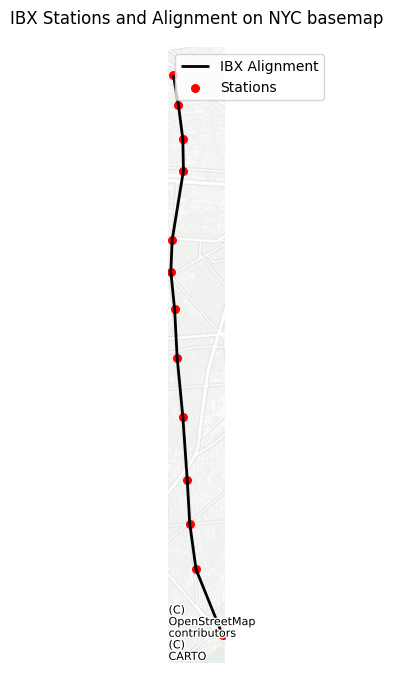

In [4]:
# Plot stations and IBX alignment on a NYC basemap.

fig, ax = plt.subplots(figsize=(8, 8))

# Reproject to Web Mercator for tile overlay
alignment_web = alignment_gdf.to_crs(epsg=3857)
stations_web = stations_gdf.to_crs(epsg=3857)

alignment_web.plot(ax=ax, color="black", linewidth=2, label="IBX Alignment")
stations_web.plot(ax=ax, color="red", markersize=30, label="Stations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857")
ax.set_title("IBX Stations and Alignment on NYC basemap")
ax.legend()
ax.set_axis_off()
plt.show()

## 2. Construct 0.3-Mile IBX Corridor Buffer

Here we:

1. Project the IBX alignment from WGS84 into **EPSG:2263** (feet), matching MapPLUTO.
2. Buffer the alignment by **0.3 miles**.
3. Keep the buffer in EPSG:2263 for clean intersection with parcels, with an optional WGS84 export for mapping.

This yields a **corridor band** approximating a half-mile walkshed around the IBX right-of-way.


In [5]:
# Buffer each station by walkshed and dissolve contiguous polygons.


def build_station_walkshed(
    stations_gdf: gpd.GeoDataFrame,
    buffer_distance_ft: float = WALKSHED_FEET,
    to_crs: str = CRS_NY_FT,
) -> gpd.GeoDataFrame:
    """Buffer each station by the given distance and return a dissolved polygon in EPSG:2263."""
    pts_proj = stations_gdf.to_crs(to_crs)
    buffers = pts_proj.buffer(buffer_distance_ft)
    dissolved = buffers.unary_union
    buffer_gdf = gpd.GeoDataFrame(
        {"buffer_ft": [buffer_distance_ft]}, geometry=[dissolved], crs=to_crs
    )
    return buffer_gdf


ibx_buffer_gdf = build_station_walkshed(stations_gdf, buffer_distance_ft=WALKSHED_FEET)

print("Station-based IBX buffer geometry (EPSG:2263):")
ibx_buffer_gdf.head()


Station-based IBX buffer geometry (EPSG:2263):


/var/folders/yv/300j0ntj6dv5tcdh12jpz9z00000gn/T/ipykernel_48745/1930460719.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dissolved = buffers.unary_union


,buffer_ft,geometry
0,1584.0,"MULTIPOLYGON (((1005068.473 175978.136, 100501..."


/var/folders/yv/300j0ntj6dv5tcdh12jpz9z00000gn/T/ipykernel_48745/240104147.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


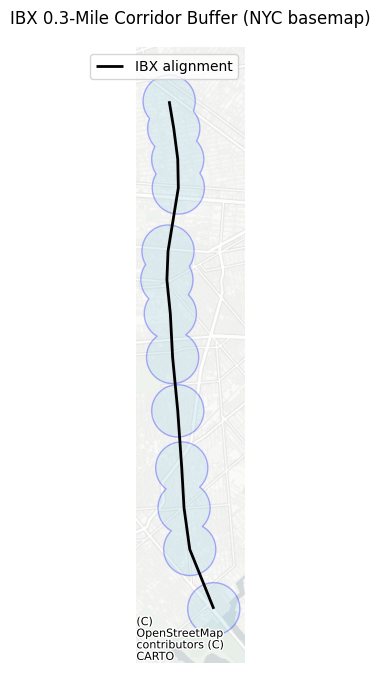

In [6]:
# Visual sanity check: IBX buffer and alignment on NYC basemap.

fig, ax = plt.subplots(figsize=(8, 8))

buffer_web = ibx_buffer_gdf.to_crs(epsg=3857)
align_web = alignment_gdf.to_crs(epsg=3857)

buffer_web.plot(
    ax=ax, color="lightblue", alpha=0.3, edgecolor="blue", label="0.3 mile buffer"
)
align_web.plot(ax=ax, color="black", linewidth=2, label="IBX alignment")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857")
ax.set_title("IBX 0.3-Mile Corridor Buffer (NYC basemap)")
ax.legend()
ax.set_axis_off()
plt.show()


## 3. Load Parcel Geometries (MapPLUTO) and Link DOF Market Land Values

This step:

1. Loads **MapPLUTO** parcel geometries from the file geodatabase at `data/nyc_mappluto_25v3_fgdb` (layer `MapPLUTO_25v3_clipped`), in **EPSG:2263**.  
2. Loads the **DOF assessment CSV** containing `CURMKTLAND` and other fields.
3. Ensures both datasets share a common **BBL identifier** (constructed from BORO/BLOCK/LOT where needed).  
4. Merges **current market land value** (`CURMKTLAND`) onto MapPLUTO parcels.
5. Uses MapPLUTO’s **`AssessLand`** as the parcel-level **assessed land value**, avoiding redundant DOF assessed fields.


In [7]:
# Load DOF, filter to YEAR==2026, report coverage, sum values, and merge into MapPLUTO

TARGET_YEAR = 2026

# ---- DOF load/clean/filter ----
dof_df = pd.read_csv(VALUATION_CSV_PATH, dtype=str, low_memory=False)
required = {"YEAR", "CURMKTLAND", "CURMKTTOT"}
missing = required - set(dof_df.columns)
if missing:
    raise KeyError(f"Missing columns in DOF CSV: {missing}")

# Ensure BBL exists
if "BBL" not in dof_df.columns:
    dof_df = add_bbl_column(dof_df, VALUATION_ID_COLS, bbl_col_name="BBL")

# Clean numerics
for col in ["CURMKTLAND", "CURMKTTOT"]:
    dof_df[col] = (
        dof_df[col]
        .astype(str)
        .str.replace(r"[^0-9.\-]", "", regex=True)
        .replace("", pd.NA)
        .astype(float)
    )
dof_df["YEAR"] = pd.to_numeric(dof_df["YEAR"], errors="coerce")

# Coverage by YEAR (all years)
df_nonnull_year = dof_df.dropna(subset=["YEAR"])
total_bbls = df_nonnull_year["BBL"].nunique()
year_counts = df_nonnull_year.groupby("YEAR")["BBL"].nunique().sort_index()
year_share = (year_counts / total_bbls * 100).round(2)
coverage_df = pd.DataFrame(
    {
        "year": year_counts.index,
        "bbl_count": year_counts.values,
        "percent_of_bbls": year_share.values,
    }
)

print("=== BBL coverage by YEAR ===")
print(f"Total unique BBLs with a YEAR: {total_bbls:,}")
display(coverage_df)

# Keep only TARGET_YEAR records and dedupe by BBL
dof_2026 = dof_df[dof_df["YEAR"] == TARGET_YEAR].sort_values(
    ["BBL", "YEAR"], ascending=[True, False]
)
dof_2026 = dof_2026.drop_duplicates(subset=["BBL"], keep="first")

tot_land_2026 = dof_2026["CURMKTLAND"].sum(skipna=True)
tot_total_2026 = dof_2026["CURMKTTOT"].sum(skipna=True)

fmt_money = "${:,.0f}".format
print(f"\n=== DOF Totals (YEAR == {TARGET_YEAR}, deduped by BBL) ===")
print(f"Rows after filter/dedupe: {len(dof_2026):,}")
print(f"CURMKTLAND (market land):  {fmt_money(tot_land_2026)}")
print(f"CURMKTTOT (market total): {fmt_money(tot_total_2026)}")

# ---- MapPLUTO load and merge with 2026 valuations ----
parcels_gdf = gpd.read_file(PLUTO_FGDB_PATH, layer=PLUTO_LAYER_NAME)
parcels_gdf = project_gdf(parcels_gdf, to_crs=CRS_NY_FT)
parcels_gdf = add_bbl_column(parcels_gdf, PARCEL_ID_COLS, bbl_col_name="BBL")

valuation_df = dof_2026[["BBL"] + list(VALUATION_VALUE_FIELDS.values())].copy()
parcels_with_values_gdf = parcels_gdf.merge(
    valuation_df,
    on="BBL",
    how="left",
    validate="1:1",
)

# Ensure MapPLUTO assessed fields numeric
for col in (PLUTO_ASSESSED_LAND_COL, PLUTO_TOTAL_VALUE_COL):
    if col in parcels_with_values_gdf.columns:
        parcels_with_values_gdf[col] = pd.to_numeric(
            parcels_with_values_gdf[col], errors="coerce"
        )
    else:
        raise KeyError(f"Expected MapPLUTO column '{col}' not found.")

preview_cols = ["BBL", PLUTO_ASSESSED_LAND_COL, PLUTO_TOTAL_VALUE_COL] + list(
    VALUATION_VALUE_FIELDS.values()
)
money_cols = preview_cols[1:]
display(
    parcels_with_values_gdf[preview_cols]
    .head()
    .style.format({c: fmt_money for c in money_cols})
)


=== BBL coverage by YEAR ===
Total unique BBLs with a YEAR: 1,163,789


,year,bbl_count,percent_of_bbls
0,2023,1142834,98.20
1,2024,1149640,98.78
2,2025,1154441,99.20
3,2026,1160405,99.71



=== DOF Totals (YEAR == 2026, deduped by BBL) ===
Rows after filter/dedupe: 1,160,405
CURMKTLAND (market land):  $412,672,920,373
CURMKTTOT (market total): $1,912,064,829,385


,BBL,AssessLand,AssessTot,CURMKTLAND,CURMKTTOT
0,1000010112,"$97,538","$180,450","$216,751","$401,000"
1,1000010201,"$14,972,400","$111,512,250","$33,272,000","$247,805,000"
2,1000020003,"$735,750","$845,550","$1,635,000","$1,879,000"
3,1000030001,"$103,167,471","$133,326,450","$229,261,046","$296,281,000"
4,1000050010,"$20,880,000","$108,214,650","$46,400,000","$240,477,000"


## 4. Select IBX-Proximate, Value-Capture-Eligible Parcels

We now:

1. Select MapPLUTO parcels whose geometry intersects the **0.3-mile IBX buffer** (all work in EPSG:2263).
2. Apply **eligibility filters** to remove parcels that are not plausible value-capture targets, using:
   - `OwnerType`: owner categories (e.g., private vs public).
   - `LandUse`: 11 land-use categories derived from DOF building classes.

Illustrative heuristic (tunable):

- **Eligible OwnerType**: P (private) and blank (unknown, usually private).  
- **Ineligible LandUse**: 07 (Transportation & Utility), 08 (Public Facilities & Institutions), 09 (Open Space & Outdoor Recreation), 10 (Parking Facilities), 11 (Vacant Land).  

The exact codes will depend on the legal definition of the value-capture base; this code keeps the filters centralized and easily editable.


In [8]:
# This cell defines functions to perform the buffer intersection and eligibility filtering.


def select_parcels_in_buffer(
    parcels_gdf: gpd.GeoDataFrame, buffer_gdf: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """Return parcels whose geometry intersects the IBX buffer polygon (all in EPSG:2263)."""
    parcels_proj = project_gdf(parcels_gdf, to_crs=CRS_NY_FT)
    buffer_proj = project_gdf(buffer_gdf, to_crs=CRS_NY_FT)
    buffer_union = union_all(buffer_proj.geometry)
    mask = parcels_proj.intersects(buffer_union)
    return parcels_proj.loc[mask].copy()


def filter_eligible_parcels(
    parcels_gdf: gpd.GeoDataFrame,
    owner_col: str = PLUTO_OWNER_COL,
    landuse_col: str = PLUTO_LANDUSE_COL,
) -> gpd.GeoDataFrame:
    """Keep parcels that are likely taxable; drop public owners and public/park land uses."""
    gdf = parcels_gdf.copy()

    # Drop obviously public owners; keep everything else (including unknowns)
    if owner_col in gdf.columns:
        owner_series = gdf[owner_col].fillna("").astype(str).str.upper()
        public_owner_types = {  # I believe this is complete - blanks and P are private
            "C",
            "S",
            "F",
            "A",
            "M",
            "O",
            "X",
        }  # City/State/Federal/Authority/Muni
        mask_owner = ~owner_series.isin(public_owner_types)
    else:
        mask_owner = np.ones(len(gdf), dtype=bool)

    # Drop public facilities and open space/parks; keep other uses
    if landuse_col in gdf.columns:
        landuse_series = gdf[landuse_col].astype(str).str.zfill(2)
        ineligible_landuse = {
            "07",  # 07 Transportation & Utility,
            "08",  # 08 Public Facilities & Institutions,
            "09",  # 09 Open Space & Outdoor Recreation
        }
        mask_land = ~landuse_series.isin(ineligible_landuse)
    else:
        mask_land = np.ones(len(gdf), dtype=bool)

    return gdf.loc[mask_owner & mask_land].copy()


# Execute selection and filtering
parcels_ibx_corridor_gdf = select_parcels_in_buffer(
    parcels_with_values_gdf, ibx_buffer_gdf
)
print(f"Parcels intersecting IBX 0.3-mile corridor: {len(parcels_ibx_corridor_gdf):,}")

eligible_ibx_parcels_gdf = filter_eligible_parcels(parcels_ibx_corridor_gdf)
print(f"Eligible parcels within IBX corridor: {len(eligible_ibx_parcels_gdf):,}")

preview_cols = [
    "BBL",
    PLUTO_ASSESSED_LAND_COL,
    PLUTO_TOTAL_VALUE_COL,
    VALUATION_VALUE_FIELDS["land_market_value"],
    VALUATION_VALUE_FIELDS["total_market_value"],
]
money_cols = preview_cols[1:]

fmt_money = "${:,.0f}".format
display(
    eligible_ibx_parcels_gdf[preview_cols]
    .head()
    .style.format({c: fmt_money for c in money_cols})
)


Parcels intersecting IBX 0.3-mile corridor: 18,239
Eligible parcels within IBX corridor: 17,460


,BBL,AssessLand,AssessTot,CURMKTLAND,CURMKTTOT
138537,3013350028,"$36,000","$419,850","$80,000","$933,000"
138538,3013350035,"$450,000","$2,062,800","$1,000,000","$4,584,000"
138539,3013360015,"$49,950","$231,750","$111,000","$515,000"
138541,3013380055,"$42,750","$42,750","$95,000","$95,000"
138616,3013420010,"$15,240","$114,780","$254,000","$1,913,000"


/var/folders/yv/300j0ntj6dv5tcdh12jpz9z00000gn/T/ipykernel_48745/1843302541.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


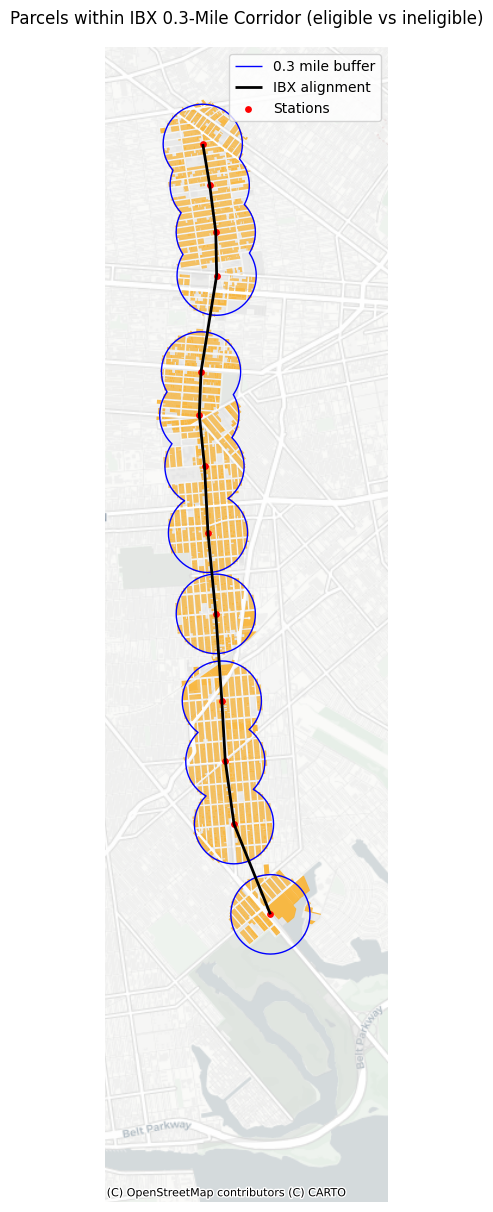

In [ ]:
# Visual inspection: parcels within IBX corridor, highlighting eligible vs ineligible (projected CRS).

fig, ax = plt.subplots(figsize=(10, 10))

# Reproject everything to Web Mercator for tile overlay
parcels_web = parcels_ibx_corridor_gdf.to_crs(epsg=3857)
eligible_web = eligible_ibx_parcels_gdf.to_crs(epsg=3857)
buffer_web = ibx_buffer_gdf.to_crs(epsg=3857)
align_web = alignment_gdf.to_crs(epsg=3857)
stations_web = stations_gdf.to_crs(epsg=3857)

parcels_web.plot(
    ax=ax, color="lightgrey", linewidth=0, alpha=0.35, label="In-corridor parcels"
)
eligible_web.plot(
    ax=ax, color="orange", linewidth=0, alpha=0.7, label="Eligible parcels"
)
buffer_web.boundary.plot(ax=ax, color="blue", linewidth=1, label="0.3 mile buffer")
align_web.plot(ax=ax, color="black", linewidth=2, label="IBX alignment")
stations_web.plot(ax=ax, color="red", markersize=15, label="Stations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857")
ax.set_title("Parcels within IBX 0.3-Mile Corridor (eligible vs ineligible)")
ax.legend()
ax.set_axis_off()
plt.show()

In [10]:
# Estimate what percent of total NYC land area falls within the IBX walkshed

FT2_PER_SQMILE = 5280 * 5280
FT2_PER_ACRE = 43560

# Ensure projected to feet (EPSG:2263)
parcels_proj = parcels_gdf.to_crs(CRS_NY_FT)
walkshed_proj = ibx_buffer_gdf.to_crs(CRS_NY_FT)
walkshed_union = walkshed_proj.unary_union

# Area of all parcels (ft^2)
total_area_ft2 = parcels_proj.geometry.area.sum()

# Area of parcel portions inside the walkshed (ft^2)
intersections = parcels_proj.intersection(walkshed_union)
captured_area_ft2 = intersections.area.sum()

percent_captured = (captured_area_ft2 / total_area_ft2) * 100


def fmt_area(ft2):
    return f"{ft2 / FT2_PER_SQMILE:,.2f} sq mi ({ft2 / FT2_PER_ACRE:,.1f} acres)"


print("=== NYC Land Capture Within IBX Walkshed ===")
print(f"Total parcel area:      {fmt_area(total_area_ft2)}")
print(f"Captured parcel area:   {fmt_area(captured_area_ft2)}")
print(f"Share of NYC parcels:   {percent_captured:.2f}%")


/var/folders/yv/300j0ntj6dv5tcdh12jpz9z00000gn/T/ipykernel_48745/1385453558.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  walkshed_union = walkshed_proj.unary_union


=== NYC Land Capture Within IBX Walkshed ===
Total parcel area:      226.70 sq mi (145,089.3 acres)
Captured parcel area:   2.13 sq mi (1,360.0 acres)
Share of NYC parcels:   0.94%


## 5. Baseline Land Value and Uplift Scenarios

For parcels that are both:

- within the **0.3-mile IBX corridor**, and
- **eligible** for value capture,

we:

1. Sum baseline **market land value** (`CURMKTLAND`) and **assessed land value** (`AssessLand`).
2. Compute scenario land values under **4%, 6%, 8%, and 10%** uplift assumptions.
3. Store the results in a tidy DataFrame for later use in the value-capture calculations.


In [11]:
# Baseline and uplift scenarios for land + total market/assessed values

land_mv_col = VALUATION_VALUE_FIELDS["land_market_value"]
total_mv_col = VALUATION_VALUE_FIELDS["total_market_value"]
land_av_col = PLUTO_ASSESSED_LAND_COL
total_av_col = PLUTO_TOTAL_VALUE_COL


def compute_baseline_and_uplifts(
    parcels_gdf: gpd.GeoDataFrame,
    uplift_rates: Iterable[float] = UPLIFT_RATES,
    land_mv_col: str = land_mv_col,
    total_mv_col: str = total_mv_col,
    land_av_col: str = land_av_col,
    total_av_col: str = total_av_col,
) -> pd.DataFrame:
    """Compute baseline and uplift scenarios for eligible parcels (land + total)."""
    baseline_land_mv = parcels_gdf[land_mv_col].sum(skipna=True)
    baseline_total_mv = parcels_gdf[total_mv_col].sum(skipna=True)
    baseline_land_av = parcels_gdf[land_av_col].sum(skipna=True)
    baseline_total_av = parcels_gdf[total_av_col].sum(skipna=True)

    records = []
    for r in uplift_rates:
        scenario_land_mv = baseline_land_mv * (1 + r)
        scenario_total_mv = baseline_total_mv * (1 + r)
        records.append(
            {
                "uplift_rate": r,
                "baseline_land_market_value": baseline_land_mv,
                "baseline_total_market_value": baseline_total_mv,
                "baseline_land_assessed_value": baseline_land_av,
                "baseline_total_assessed_value": baseline_total_av,
                "scenario_land_market_value": scenario_land_mv,
                "scenario_total_market_value": scenario_total_mv,
                "incremental_land_value": scenario_land_mv - baseline_land_mv,
                "incremental_total_value": scenario_total_mv - baseline_total_mv,
            }
        )
    return pd.DataFrame(records)


uplift_summary_df = compute_baseline_and_uplifts(eligible_ibx_parcels_gdf)

fmt_money = "${:,.0f}".format
fmt_pct = "{:.0%}".format
money_cols = [
    "baseline_land_market_value",
    "baseline_total_market_value",
    "baseline_land_assessed_value",
    "baseline_total_assessed_value",
    "scenario_land_market_value",
    "scenario_total_market_value",
    "incremental_land_value",
    "incremental_total_value",
]

display(
    uplift_summary_df.style.format(
        {c: fmt_money for c in money_cols} | {"uplift_rate": fmt_pct}
    )
)


,uplift_rate,baseline_land_market_value,baseline_total_market_value,baseline_land_assessed_value,baseline_total_assessed_value,scenario_land_market_value,scenario_total_market_value,incremental_land_value,incremental_total_value
0,4%,"$4,133,777,963","$18,812,554,385","$499,221,610","$2,778,194,374","$4,299,129,082","$19,565,056,560","$165,351,119","$752,502,175"
1,6%,"$4,133,777,963","$18,812,554,385","$499,221,610","$2,778,194,374","$4,381,804,641","$19,941,307,648","$248,026,678","$1,128,753,263"
2,8%,"$4,133,777,963","$18,812,554,385","$499,221,610","$2,778,194,374","$4,464,480,200","$20,317,558,736","$330,702,237","$1,505,004,351"
3,10%,"$4,133,777,963","$18,812,554,385","$499,221,610","$2,778,194,374","$4,547,155,759","$20,693,809,824","$413,377,796","$1,881,255,438"


## 6. Gupta Rough Value Capture Tax-Rate Estimation

We adopt a simplified version of the Gupta–Van Nieuwerburgh–Kontokosta framework:

1. For each uplift scenario, let \( ΔV \) be the **incremental market land value** in the IBX corridor.
2. Assume the existing tax system passively captures a fixed share \( θ \) of that uplift in present value (default \( θ = 0.306 \)).
3. Remaining unfunded cost: \( C_{gap} = \max(C - θ ΔV, 0) \), where \( C \) is IBX capital cost.
4. Assume a constant **annual surcharge rate** \( τ \) on the uplifted land value (\( \ΔV \)) over \( T \) years at discount rate \( r \):
   - Annual surcharge revenue: \( τ ΔV \).
   - Present value: \( τ \ΔV A(r, T) \), where \( A(r, T) = \frac{1 - (1+r)^{-T}}{r} \).
   - Solve for \( τ \) such that \( τ \ΔV A(r,T) = C_{gap} \):
     \[
     τ = \frac{C_{gap}}{\ΔV A(r, T)}.
     \]

We report \( τ \) as an **annual value-capture tax rate** on the incremental land value (e.g., 0.5% of uplift per year).


In [12]:
# Value-capture functions using the simplified Gupta-style framework.


def annuity_factor(r: float, T: int) -> float:
    """Present-value factor of a $1-per-year annuity over T years at rate r."""
    if r <= 0:
        return float(T)
    return (1 - (1 + r) ** (-T)) / r


def compute_surcharge_rate_for_scenario(
    incremental_value: float,
    capital_cost: float = IBX_CAPITAL_COST,
    passive_capture_share: float = PASSIVE_CAPTURE_SHARE,
    discount_rate: float = DISCOUNT_RATE,
    horizon_years: int = HORIZON_YEARS,
):
    """Compute funding gap and implied annual surcharge rate on uplifted value."""
    passive_capture_pv = passive_capture_share * incremental_value
    funding_gap = max(capital_cost - passive_capture_pv, 0)
    A = annuity_factor(discount_rate, horizon_years)

    if incremental_value <= 0 or A <= 0 or funding_gap == 0:
        surcharge_rate = 0.0
    else:
        surcharge_rate = funding_gap / (incremental_value * A)

    return {
        "passive_capture_pv": passive_capture_pv,
        "funding_gap": funding_gap,
        "surcharge_rate": surcharge_rate,
    }


def attach_value_capture_results(
    uplift_df: pd.DataFrame,
    incremental_col: str,
    prefix: str,
    capital_cost: float = IBX_CAPITAL_COST,
    passive_capture_share: float = PASSIVE_CAPTURE_SHARE,
    discount_rate: float = DISCOUNT_RATE,
    horizon_years: int = HORIZON_YEARS,
) -> pd.DataFrame:
    """Add capture metrics for a given incremental value column with prefixed names."""

    def _row_calc(row):
        vc = compute_surcharge_rate_for_scenario(
            incremental_value=row[incremental_col],
            capital_cost=capital_cost,
            passive_capture_share=passive_capture_share,
            discount_rate=discount_rate,
            horizon_years=horizon_years,
        )
        return pd.Series(
            {
                f"passive_capture_pv_{prefix}": vc["passive_capture_pv"],
                f"funding_gap_{prefix}": vc["funding_gap"],
                f"surcharge_rate_{prefix}": vc["surcharge_rate"],
            }
        )

    vc_block = uplift_df.apply(_row_calc, axis=1)
    return pd.concat([uplift_df.reset_index(drop=True), vc_block], axis=1)


# Attach capture metrics for land and total market uplift
value_capture_df = attach_value_capture_results(
    uplift_summary_df, incremental_col="incremental_land_value", prefix="land"
)
value_capture_df = attach_value_capture_results(
    value_capture_df, incremental_col="incremental_total_value", prefix="total"
)

# Display with human-readable formatting
cols = [
    "uplift_rate",
    "baseline_land_market_value",
    "baseline_total_market_value",
    "scenario_land_market_value",
    "scenario_total_market_value",
    "incremental_land_value",
    "incremental_total_value",
    "passive_capture_pv_land",
    "funding_gap_land",
    "surcharge_rate_land",
    "passive_capture_pv_total",
    "funding_gap_total",
    "surcharge_rate_total",
]

fmt_money = "${:,.0f}".format
fmt_pct = "{:.0%}".format
fmt_rate = "{:.3%}".format  # surcharge per year

display(
    value_capture_df[cols].style.format(
        {
            "uplift_rate": fmt_pct,
            "surcharge_rate_land": fmt_rate,
            "surcharge_rate_total": fmt_rate,
            **{
                c: fmt_money
                for c in cols
                if c
                not in {"uplift_rate", "surcharge_rate_land", "surcharge_rate_total"}
            },
        }
    )
)


,uplift_rate,baseline_land_market_value,baseline_total_market_value,scenario_land_market_value,scenario_total_market_value,incremental_land_value,incremental_total_value,passive_capture_pv_land,funding_gap_land,surcharge_rate_land,passive_capture_pv_total,funding_gap_total,surcharge_rate_total
0,4%,"$4,133,777,963","$18,812,554,385","$4,299,129,082","$19,565,056,560","$165,351,119","$752,502,175","$50,597,442","$5,449,402,558",168.142%,"$230,265,666","$5,269,734,334",35.729%
1,6%,"$4,133,777,963","$18,812,554,385","$4,381,804,641","$19,941,307,648","$248,026,678","$1,128,753,263","$75,896,163","$5,424,103,837",111.574%,"$345,398,499","$5,154,601,501",23.299%
2,8%,"$4,133,777,963","$18,812,554,385","$4,464,480,200","$20,317,558,736","$330,702,237","$1,505,004,351","$101,194,885","$5,398,805,115",83.290%,"$460,531,331","$5,039,468,669",17.084%
3,10%,"$4,133,777,963","$18,812,554,385","$4,547,155,759","$20,693,809,824","$413,377,796","$1,881,255,438","$126,493,606","$5,373,506,394",66.320%,"$575,664,164","$4,924,335,836",13.355%


## 7. Final Summary

This cell prints a concise summary of:

- Baseline summed **market land value** (`CURMKTLAND`) and **assessed land value** (`AssessLand`) in the IBX corridor (eligible parcels only).
- Scenario uplift values (4%, 6%, 8%, 10%).
- IBX capital cost and Gupta-style assumptions.
- Implied annual value-capture surcharge rates needed to close the funding gap under each scenario.


In [13]:
# Human-readable summary of key results (land + total)

baseline = uplift_summary_df.iloc[0]
print("=== IBX Land Value and Value Capture Summary ===\n")
print(f"Eligible IBX-corridor parcels: {len(eligible_ibx_parcels_gdf):,}")
print(
    f"Baseline land MARKET value (CURMKTLAND):   ${baseline['baseline_land_market_value']:,.0f}"
)
print(
    f"Baseline total MARKET value (CURMKTTOT):  ${baseline['baseline_total_market_value']:,.0f}"
)
print(
    f"Baseline land ASSESSED value (AssessLand): ${baseline['baseline_land_assessed_value']:,.0f}"
)
print(
    f"Baseline total ASSESSED value (AssessTot): ${baseline['baseline_total_assessed_value']:,.0f}\n"
)
print(
    f"IBX capital cost assumption:         ${IBX_CAPITAL_COST:,.0f}.\nNote that this is 2027 dollars while appraisals are in 2026(?) dollars."
)
print(f"Passive capture share (per Gupta): {PASSIVE_CAPTURE_SHARE:.3f}")
print(f"Discount rate:                       {DISCOUNT_RATE:.3%}")
print(f"Horizon (years):                     {HORIZON_YEARS}\n")

for _, row in value_capture_df.iterrows():
    print(f"Uplift scenario: {row['uplift_rate'] * 100:.0f}%")
    print(f"  Incremental land value:     ${row['incremental_land_value']:,.0f}")
    print(f"  Passive capture PV (land):  ${row['passive_capture_pv_land']:,.0f}")
    print(f"  Funding gap (land):         ${row['funding_gap_land']:,.0f}")
    print(
        f"  Surcharge rate (land):      {row['surcharge_rate_land'] * 100:.3f}% per year"
    )
    print(f"  Incremental TOTAL value:    ${row['incremental_total_value']:,.0f}")
    print(f"  Passive capture PV (total): ${row['passive_capture_pv_total']:,.0f}")
    print(f"  Funding gap (total):        ${row['funding_gap_total']:,.0f}")
    print(
        f"  Surcharge rate (total):     {row['surcharge_rate_total'] * 100:.3f}% per year\n"
    )

=== IBX Land Value and Value Capture Summary ===

Eligible IBX-corridor parcels: 17,460
Baseline land MARKET value (CURMKTLAND):   $4,133,777,963
Baseline total MARKET value (CURMKTTOT):  $18,812,554,385
Baseline land ASSESSED value (AssessLand): $499,221,610
Baseline total ASSESSED value (AssessTot): $2,778,194,374

IBX capital cost assumption:         $5,500,000,000.
Note that this is 2027 dollars while appraisals are in 2026(?) dollars.
Passive capture share (per Gupta): 0.306
Discount rate:                       3.000%
Horizon (years):                     30

Uplift scenario: 4%
  Incremental land value:     $165,351,119
  Passive capture PV (land):  $50,597,442
  Funding gap (land):         $5,449,402,558
  Surcharge rate (land):      168.142% per year
  Incremental TOTAL value:    $752,502,175
  Passive capture PV (total): $230,265,666
  Funding gap (total):        $5,269,734,334
  Surcharge rate (total):     35.729% per year

Uplift scenario: 6%
  Incremental land value:     $24